In [63]:
import os, sys
sys.path.append('C:\\Users\\matthias\\Documents\\myProjects\\TU_Bibliothek\\code\\baseline-extract')
#from src.inference.models import LineDetector
from src.segmentation.gcn_model import GCN
from src.data.dataset_line_rider import DatasetLineRider
from src.utils.distances import get_median_diff, d2, get_smallest_distance

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
import numpy as np
import cv2
import torch

class LineDetector:
    """
    Loads the line rider model for inference.
    """
    def __init__(self, line_rider_weights: str, line_finder_weights: str, device_lr: str, device_lf: str):
        self.line_rider = self.load_line_rider_model(line_rider_weights, device_lr)
        self.line_finder_seg = self.load_line_finder_model(line_finder_weights, device_lf)

    def load_line_rider_model(self, weights, device):
        model = torch.load(weights, map_location=device)
        model.to(device)
        model.eval()

        return model

    def load_line_finder_model(self, weights, device):
        seg_model = GCN(n_classes=6, resnet_depth=50)
        seg_model.load_state_dict(torch.load(weights, map_location=device))
        seg_model.to(device)
        seg_model.eval()

        return seg_model

    def segmentation_postprocessing(self, array: np.array, sigma, threshold, morph_close_size, erode_size):
        out = cv2.GaussianBlur(array, (int(3 * sigma) * 2 + 1, int(3 * sigma) * 2 + 1), sigma)
        out = (out > threshold) * 1.0
        out = cv2.morphologyEx(out, cv2.MORPH_CLOSE, (morph_close_size, morph_close_size))
        out = cv2.erode(out, (erode_size, erode_size), iterations=1)

        return out

    def extract_start_points_and_angles(self, segmentation: np.array) -> tuple:
        probs_start_points = segmentation[:, :, 2]
        probs_end_points = segmentation[:, :, 3]
        probs_baselines = segmentation[:, :, 0]

        # Postprozessing parameters
        sigma = 0.3
        threshold = 0.95
        morph_close_size = 3
        erode_size = 3

        # Extract start points
        sp = self.segmentation_postprocessing(probs_start_points, sigma, threshold, morph_close_size, erode_size)
        _, _, _, start_points = cv2.connectedComponentsWithStats(sp.astype(np.uint8))

        # Extract end points
        ep = self.segmentation_postprocessing(probs_end_points, sigma, threshold, morph_close_size, erode_size)
        _, _, _, end_points = cv2.connectedComponentsWithStats(ep.astype(np.uint8))

        # Compute the angles and match start and end points
        probs_sum = probs_start_points + probs_end_points + probs_baselines
        ps = cv2.GaussianBlur(probs_sum, (int(3 * sigma) * 2 + 1, int(3 * sigma) * 2 + 1), sigma)
        ps = (ps > threshold) * 1.0
        ps = cv2.morphologyEx(ps, cv2.MORPH_OPEN, (3, 3))

        _, labels, stats, _ = cv2.connectedComponentsWithStats(ps.astype(np.uint8))

        # stats is a matrix where for every label l the vector stats[l] is given by:
        # [leftmost (x) coordinate, topmost (y) coordinate, width of bounding box, height of bouinding box, area]
        # see https://stackoverflow.com/questions/35854197/how-to-use-opencvs-connected-components-with-stats-in-python
        
        # Assign labels to the start and end points
        # [1:] because the background is also a component
        sp_labels = {labels[(int(p[1]), int(p[0]))]: p for p in start_points[1:]}
        ep_labels = {labels[(int(p[1]), int(p[0]))]: p for p in end_points[1:]}

        label_list = sp_labels.keys()
        angles = {l: np.arctan(stats[l][3]/ stats[l][2]) for l in label_list}

        return sp_labels, ep_labels, angles, label_list

    def extract_baselines(self, image: torch.tensor):
        image = image.unsqueeze(0)
        seg_out = self.line_finder_seg(image)[0][0]

        start_points, end_points, angles, label_list = self.extract_start_points_and_angles(seg_out.cpu().numpy())

In [3]:
line_rider_weights = os.path.join('..', 'trained_models', 'line_rider', 'line_rider_default.pt')
line_finder_weights = os.path.join('..', 'trained_models', 'segmentation', 'GCN_1024_cBAD_resnext50.pt')
device_lr = 'cpu'
device_lf = 'cpu'

parameters = {'input_folder': os.path.join('..', 'data', 'cBAD-ICDAR2019'),
              'max_side': 1024,
              'crop_size': None}

In [4]:
ld = LineDetector(line_rider_weights=line_rider_weights,
                  line_finder_weights=line_finder_weights,
                  device_lr=device_lr,
                  device_lf=device_lf)

c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'src.model.line_rider.LineRider' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [16]:
ds = DatasetLineRider(inf_type='train', parameters=parameters)

In [26]:
sample = ds[1]

In [27]:
image = sample['image'].unsqueeze(0)
seg_out = ld.line_finder_seg(image)[0][0]

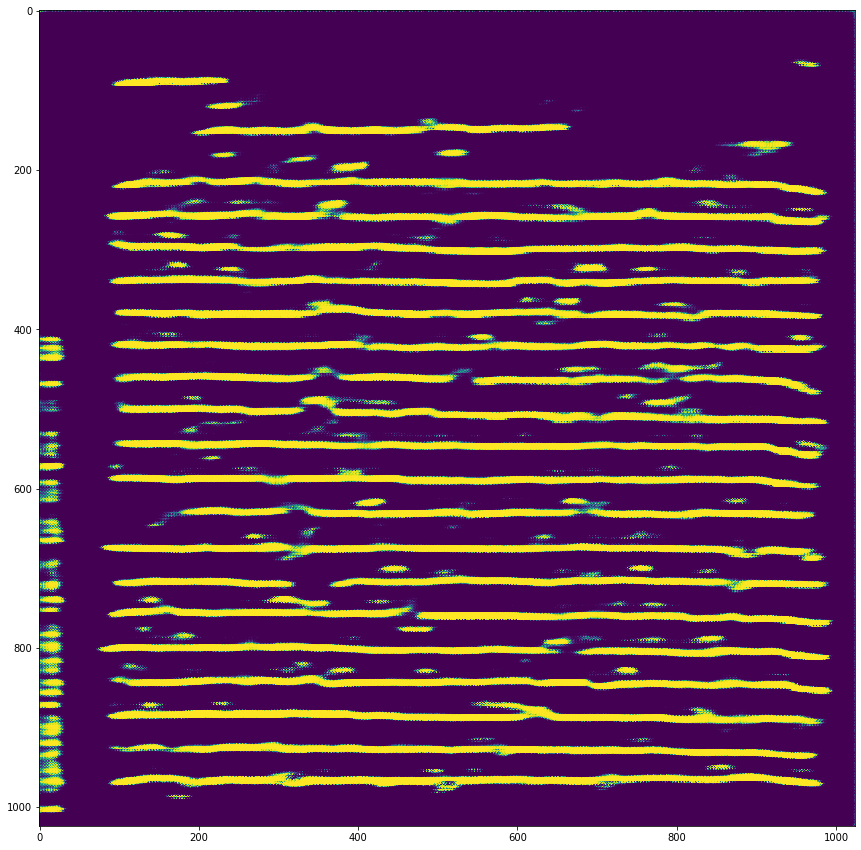

In [29]:
plt.figure(figsize=(15,15))
plt.imshow(seg_out[0,:,:].detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


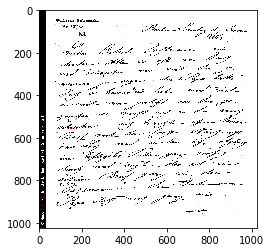

In [17]:
plt.imshow(image[0].permute(1,2,0).detach().numpy() + seg_out[0:3,:,:].permute(1,2,0).detach().numpy())

In [18]:
start_points, end_points, angles, label_list = ld.extract_start_points_and_angles(seg_out.permute(1,2,0).detach().numpy())

In [19]:
start_points.values()

dict_values([])

In [27]:
sp_list = []

for l in start_points.keys():
    sp_list.append(start_points[l])

In [30]:
sp_t = torch.tensor(sp_list)

In [32]:
get_smallest_distance(sp_t[0], sp_t)

tensor(40.1270, dtype=torch.float64)

In [34]:
torch.pow(torch.tensor(2), 2)

tensor(4)

In [16]:
start_points

{1: array([78.5       , 57.15909091]),
 2: array([106.84285714,  85.56428571]),
 3: array([478.21167883, 102.91240876]),
 4: array([181.86614173, 125.70866142]),
 5: array([778.01796407, 138.03592814]),
 8: array([109.61111111, 211.90277778]),
 9: array([ 96.65178571, 266.66071429]),
 10: array([ 90.25179856, 309.24460432]),
 11: array([ 87.07258065, 355.72580645]),
 12: array([ 89.90344828, 408.57931034]),
 13: array([ 93.25899281, 455.75539568]),
 14: array([ 81.07142857, 511.49107143]),
 16: array([ 81.47619048, 561.95238095]),
 17: array([ 86.30894309, 610.21138211]),
 18: array([ 88.34693878, 655.51020408]),
 19: array([ 89.79439252, 707.6635514 ]),
 20: array([ 82.54263566, 761.2248062 ]),
 21: array([ 86.48648649, 807.59459459]),
 22: array([ 94.83333333, 859.2       ]),
 23: array([ 79.69158879, 920.85981308])}

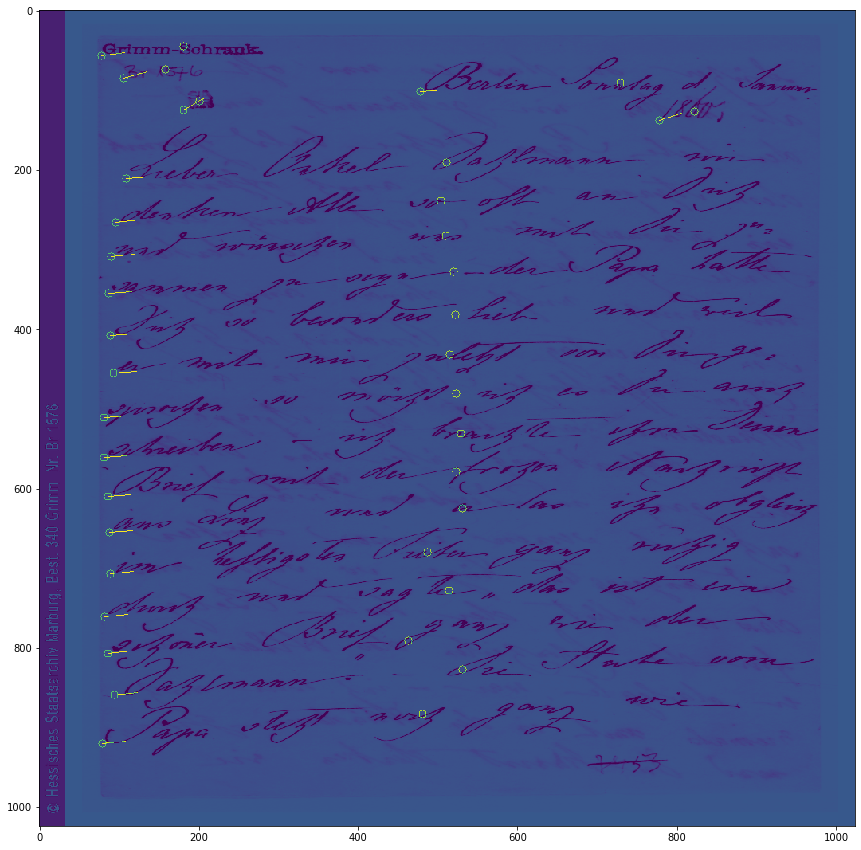

In [13]:
mask_img = np.zeros(image[0,0].shape, dtype=np.uint8)

for l in label_list:
    p = tuple(start_points[l].astype(int))
    cv2.circle(mask_img, p, radius=5, color=8, thickness=1, lineType=8, shift=0)
    angle = angles[l]
    p2 = (int(p[0] + 30*np.cos(angle)), int(p[1] - 30*np.sin(angle)))
    cv2.line(mask_img, p, p2, color=12)
    
    p = end_points[l]
    cv2.circle(mask_img, tuple(p.astype(int)), radius=5, color=10, thickness=1, lineType=8, shift=0)
    
plt.figure(figsize=(15,15))
plt.imshow(mask_img+image[0,0,:,:].detach().numpy())

In [14]:
for x in start_points.values():
    print(x)

[78.5        57.15909091]
[106.84285714  85.56428571]
[478.21167883 102.91240876]
[181.86614173 125.70866142]
[778.01796407 138.03592814]
[109.61111111 211.90277778]
[ 96.65178571 266.66071429]
[ 90.25179856 309.24460432]
[ 87.07258065 355.72580645]
[ 89.90344828 408.57931034]
[ 93.25899281 455.75539568]
[ 81.07142857 511.49107143]
[ 81.47619048 561.95238095]
[ 86.30894309 610.21138211]
[ 88.34693878 655.51020408]
[ 89.79439252 707.6635514 ]
[ 82.54263566 761.2248062 ]
[ 86.48648649 807.59459459]
[ 94.83333333 859.2       ]
[ 79.69158879 920.85981308]


In [193]:
x = torch.tensor(100.12)

In [195]:
if x > 0:
    print(min(x, 2000))

tensor(100.1200)


In [196]:
int(x)

100